In [1]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv("CSV_DEF.csv")

# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Binarizar la variable objetivo
neurodiv = ["TDAH", "Autismo", "Dislexia"]
df["target"] = df["variable"].apply(lambda x: 1 if x in neurodiv else 0)

# Comprobación
print("Distribución de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

# Mostrar distribución de la variable binaria
print(df["target"].value_counts())
df[["variable", "target"]].head()

Distribución de clases tras eliminar Dispraxia:
variable
Control     6155
Autismo     2113
TDAH        2030
Dislexia    2026
Name: count, dtype: int64
target
1    6169
0    6155
Name: count, dtype: int64


,variable,target
0,TDAH,1
1,TDAH,1
2,Autismo,1
3,Autismo,1
4,Autismo,1


In [2]:
# 1. Eliminar columnas no numéricas o irrelevantes
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable'  # variable ya está incluida como target
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True, errors='ignore')

# 3. Rellenar nulos por tipo de dato
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"🟦 Columna categórica '{col}' rellenada con su moda")

# 4. Comprobar que no quedan nulos
print("✅ Nulos restantes tras limpieza:", df.isnull().sum().sum())

# 5. Separar X (predictoras) e y (target)
X = df.drop(columns='target')
y = df['target']

# Mostrar dimensiones finales
print(f"✅ Dimensiones finales: X = {X.shape}, y = {y.shape}")

🟦 Columna categórica 'most_frequent_dominant_emotion' rellenada con su moda
🟦 Columna categórica 'voice_mean_note' rellenada con su moda
🟦 Columna categórica 'voice_median_note' rellenada con su moda
🟦 Columna categórica 'voice_mode_note' rellenada con su moda
🟦 Columna categórica 'voice_Q25_note' rellenada con su moda
🟦 Columna categórica 'voice_Q75_note' rellenada con su moda
🟦 Columna categórica 'language' rellenada con su moda
✅ Nulos restantes tras limpieza: 0
✅ Dimensiones finales: X = (12324, 66), y = (12324,)


In [3]:
# Columnas categóricas con texto que hay que eliminar
columnas_categoricas = [
    'most_frequent_dominant_emotion',
    'voice_mean_note',
    'voice_median_note',
    'voice_mode_note',
    'voice_Q25_note',
    'voice_Q75_note',
    'language'
]

# Eliminar del conjunto X
X = X.drop(columns=columnas_categoricas, errors='ignore')

# Confirmamos las nuevas dimensiones
print(f"✅ Nuevas dimensiones de X tras eliminar texto: {X.shape}")

✅ Nuevas dimensiones de X tras eliminar texto: (12324, 59)


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

📊 Matriz de confusión:
 [[1099  433]
 [ 496 1053]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.69      0.72      0.70      1532
           1       0.71      0.68      0.69      1549

    accuracy                           0.70      3081
   macro avg       0.70      0.70      0.70      3081
weighted avg       0.70      0.70      0.70      3081

🧮 AUC: 0.7568704310200972


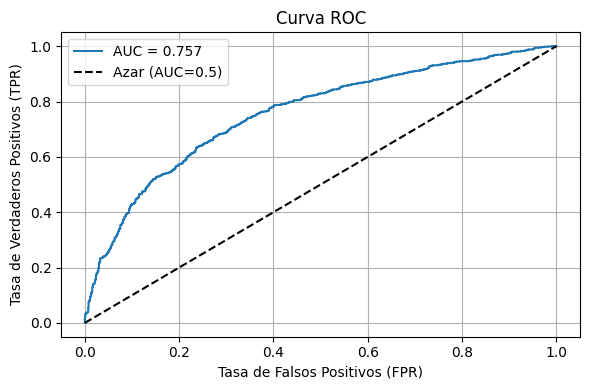

In [14]:
# 3. Entrenamiento
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predicciones y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧮 AUC:", roc_auc_score(y_test, y_prob))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Crear copia de X_train como DataFrame con índices de y_train
X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)

# Añadir constante
X_train_df = sm.add_constant(X_train_df)

# Entrenar modelo logit
logit_model = sm.Logit(y_train, X_train_df).fit()

# Mostrar resultados
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.592964
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9243
Model:                          Logit   Df Residuals:                     9183
Method:                           MLE   Df Model:                           59
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                  0.1445
Time:                        09:58:39   Log-Likelihood:                -5480.8
converged:                       True   LL-Null:                       -6406.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0270      0.023      1.163      0.245      -0.019   

----

Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                0.009010
Time:                        10:12:00   Log-Likelihood:                -8465.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 6.046e-30
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0036      0.018      0.198      0.843      -0.032       0.039
angry_facial  

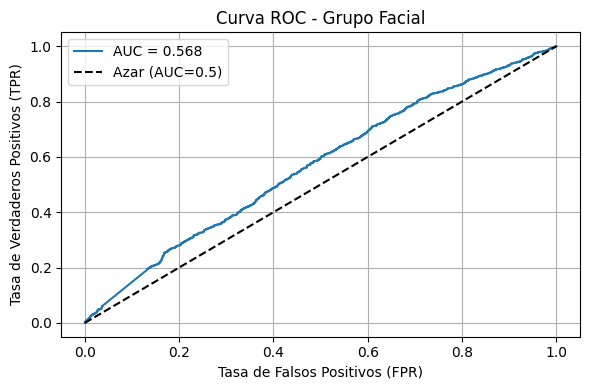

📊 Matriz de confusión:
 [[4155 2000]
 [3709 2460]]


In [24]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables faciales
facial_cols = [
    'angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial',
    'sad_facial', 'surprise_facial', 'neutral_facial'
]

# 2. Preparar X e y
X_facial = df[facial_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_facial_scaled = scaler.fit_transform(X_facial)

# 4. Crear DataFrame alineado con y
X_facial_df = pd.DataFrame(X_facial_scaled, columns=facial_cols, index=y.index)
X_facial_df = sm.add_constant(X_facial_df)

# 5. Modelo logit
logit_model = sm.Logit(y, X_facial_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_facial_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Facial')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))

📋 Interpretación de cada variable
Nota: Como todas las variables fueron normalizadas (z-score), sus coeficientes pueden compararse directamente. Coeficientes negativos indican que un mayor valor disminuye la probabilidad de neurodivergencia, y positivos que la aumenta.

| Variable          | Coef.  | p-valor | Significativa | Interpretación                                                             |
| ----------------- | ------ | ------- | ------------- | -------------------------------------------------------------------------- |
| `angry_facial`    | -0.229 | <0.001  | ✅             | A mayor expresión de enfado, menor probabilidad de neurodivergencia.       |
| `disgust_facial`  | +0.019 | 0.342   | ❌             | No tiene un efecto estadísticamente significativo.                         |
| `fear_facial`     | -0.171 | <0.001  | ✅             | Más miedo facial se asocia a menor neurodivergencia.                       |
| `happy_facial`    | -0.248 | <0.001  | ✅             | Mayor expresión de felicidad reduce la probabilidad.                       |
| `sad_facial`      | -0.184 | <0.001  | ✅             | Más tristeza facial también reduce la probabilidad.                        |
| `surprise_facial` | +0.056 | 0.018   | ✅             | Aumenta ligeramente la probabilidad de neurodivergencia.                   |
| `neutral_facial`  | -0.261 | <0.001  | ✅             | Una expresión más neutra se asocia fuertemente con menor neurodivergencia. |


Todas las emociones reconocidas facialmente están negativamente asociadas con neurodivergencia, salvo la sorpresa, que tiene una pequeña contribución positiva.
Esto podría reflejar que las personas neurodivergentes, en este conjunto de datos, tienden a mostrar menos expresividad emocional facial o una expresión más neutra.
La excepción de surprise_facial sugiere que ciertas emociones como la sorpresa podrían comportarse diferente, pero su efecto es menor.

Optimization terminated successfully.
         Current function value: 0.651326
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.06033
Time:                        10:11:42   Log-Likelihood:                -8026.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.504e-213
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0045      0.019      0.242      0.809      -0.032       0.041
extraver

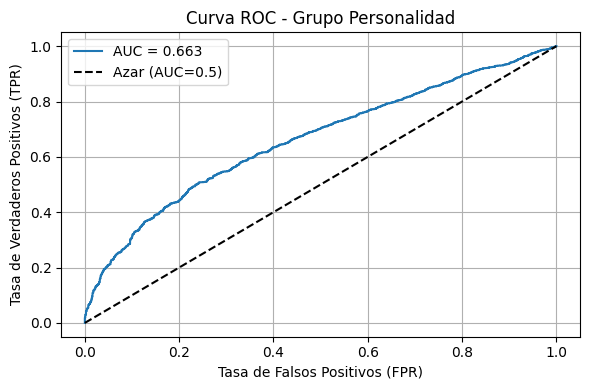

📊 Matriz de confusión:
 [[3845 2310]
 [2376 3793]]


In [23]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables de personalidad
personality_cols = [
    'extraversion', 'neuroticism', 'agreeableness',
    'conscientiousness', 'openness', 'survival', 'creativity',
    'self_esteem', 'compassion', 'communication',
    'imagination', 'awareness'
]

# 2. Preparar X e y
X_personality = df[personality_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_personality_scaled = scaler.fit_transform(X_personality)

# 4. Crear DataFrame alineado con y
X_personality_df = pd.DataFrame(X_personality_scaled, columns=personality_cols, index=y.index)
X_personality_df = sm.add_constant(X_personality_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_personality_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_personality_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Personalidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))

📈 AUC: 0.663
Mejor que el grupo facial (0.568).

Esto indica que las características de personalidad aportan más información predictiva sobre la probabilidad de neurodivergencia.

📋 Variables significativas:
| Variable            | Coef.      | Interpretación                                                                                                                                           |
| ------------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `extraversion`      | **+0.662** | Mayor extraversión → **mayor** probabilidad de neurodivergencia. Sorprendente, podría reflejar sesgo en el dataset o diferencias de estilo de expresión. |
| `neuroticism`       | **–0.212** | A mayor neuroticismo → **menor** probabilidad.                                                                                                           |
| `agreeableness`     | **+0.195** | Más amabilidad → mayor probabilidad.                                                                                                                     |
| `conscientiousness` | **+0.398** | Mayor responsabilidad/autocontrol → mayor probabilidad.                                                                                                  |
| `openness`          | **–0.506** | Más apertura a experiencias → menor probabilidad.                                                                                                        |
| `survival`          | **–0.219** | Tendencia a priorizar lo básico → menor probabilidad.                                                                                                    |
| `creativity`        | **–0.056** | Creatividad ligeramente reduce la probabilidad.                                                                                                          |


Optimization terminated successfully.
         Current function value: 0.663983
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.04207
Time:                        10:13:56   Log-Likelihood:                -8182.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.135e-146
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0107      0.019      0.575      0.565      -0.026       0.047

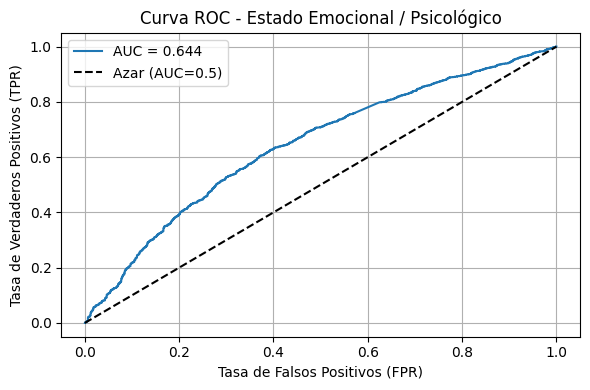

📊 Matriz de confusión:
 [[4345 1810]
 [2977 3192]]


In [25]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables de estado emocional
mental_state_cols = [
    'stress_high', 'stress_medium', 'stress_low',
    'helplessness_high', 'helplessness_medium', 'helplessness_low',
    'self_efficacy_high', 'self_efficacy_medium', 'self_efficacy_low',
    'depression_high', 'depression_medium', 'depression_low'
]

# 2. Preparar X e y
X_mental = df[mental_state_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_mental_scaled = scaler.fit_transform(X_mental)

# 4. Crear DataFrame alineado con y
X_mental_df = pd.DataFrame(X_mental_scaled, columns=mental_state_cols, index=y.index)
X_mental_df = sm.add_constant(X_mental_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_mental_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_mental_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Estado Emocional / Psicológico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))

🧠 Análisis del grupo emocional/psicológico
📈 AUC: 0.644
Mejor que el grupo facial (0.568), pero algo por debajo del de personalidad (0.663).

Este grupo aporta buena capacidad predictiva.

Refuerza que los rasgos emocionales y de bienestar están correlacionados con neurodivergencia en este dataset.

📋 Variables significativas:
| Variable               | Coef.  | Interpretación                                                                |
| ---------------------- | ------ | ----------------------------------------------------------------------------- |
| `stress_medium`        | –0.962 | Estrés medio disminuye probabilidad de neurodivergencia.                      |
| `helplessness_low`     | +0.655 | Baja indefensión → mayor probabilidad. Curioso, probablemente efecto cruzado. |
| `self_efficacy_medium` | +0.401 | Nivel medio de autoeficacia se asocia a mayor probabilidad.                   |
| `self_efficacy_high`   | +0.618 | Nivel alto de autoeficacia también aumenta probabilidad.                      |
| `depression_medium`    | –0.508 | Depresión media reduce la probabilidad.                                       |
| `depression_low`       | –0.384 | Depresión baja también reduce probabilidad.                                   |


Optimization terminated successfully.
         Current function value: 0.679878
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.01914
Time:                        10:15:56   Log-Likelihood:                -8378.8
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 9.709e-63
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0055      0.018      0.300      0.764      -0.030       0.041
voice_mean       

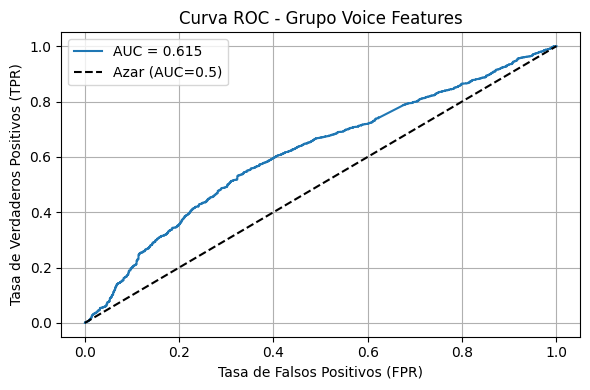

📊 Matriz de confusión:
 [[3625 2530]
 [2428 3741]]


In [26]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables vocales
voice_cols = [
    'voice_mean', 'voice_sd', 'voice_median', 'voice_mode',
    'voice_Q25', 'voice_Q75', 'voice_IQR',
    'voice_skewness', 'voice_kurtosis', 'voice_rmse',
    'pitch', 'tone'
]

# 2. Preparar X e y
X_voice = df[voice_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_voice_scaled = scaler.fit_transform(X_voice)

# 4. Crear DataFrame alineado con y
X_voice_df = pd.DataFrame(X_voice_scaled, columns=voice_cols, index=y.index)
X_voice_df = sm.add_constant(X_voice_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Voice Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))


🎙️ Análisis del grupo de características vocales
📈 AUC = 0.615
Algo mejor que azar puro y más informativo que el grupo facial (0.568).

Sin embargo, menos predictivo que personalidad (0.663) y emocional (0.644).

Esto sugiere que la manera de hablar tiene cierto valor diagnóstico, pero no es tan discriminativa por sí sola.

📋 Variables estadísticamente significativas:
| Variable       | Coef.  | Interpretación                                                            |
| -------------- | ------ | ------------------------------------------------------------------------- |
| `voice_mean`   | +0.373 | Mayor promedio de frecuencia → mayor probabilidad de neurodivergencia.    |
| `voice_sd`     | +0.334 | Más variabilidad en la señal vocal → mayor probabilidad.                  |
| `voice_median` | +0.896 | Mediana de voz alta → indicador positivo.                                 |
| `voice_mode`   | –0.083 | Contrario al anterior, más valor modal de voz reduce la probabilidad.     |
| `voice_Q25`    | +1.101 | Percentil 25 alto (tonos bajos) → mayor probabilidad.                     |
| `voice_Q75`    | –6.978 | Percentil 75 alto (tonos altos) → **fuerte disminución** de probabilidad. |
| `voice_IQR`    | +6.556 | Mayor rango intercuartílico → más neurodivergencia.                       |
| `voice_rmse`   | –0.217 | Mayor error cuadrático de la señal (menos suave) → menor probabilidad.    |


Optimization terminated successfully.
         Current function value: 0.678503
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12315
Method:                           MLE   Df Model:                            8
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.02113
Time:                        10:18:15   Log-Likelihood:                -8361.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 4.214e-73
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0057      0.018      0.310      0.757      -0.030       0.042
sad_voice     

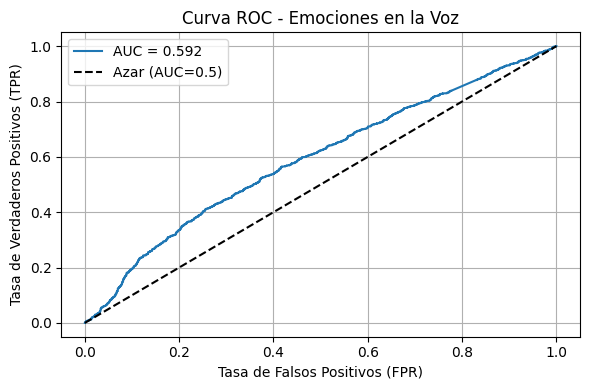

📊 Matriz de confusión:
 [[4440 1715]
 [3520 2649]]


In [28]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables emocionales de la voz
voice_emotion_cols = [
    'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice',
    'happy_voice', 'angry_voice', 'calm_voice', 'surprised_voice'
]

# 2. Preparar X e y
X_voice_emotion = df[voice_emotion_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_voice_emotion_scaled = scaler.fit_transform(X_voice_emotion)

# 4. Crear DataFrame alineado con y
X_voice_emotion_df = pd.DataFrame(X_voice_emotion_scaled, columns=voice_emotion_cols, index=y.index)
X_voice_emotion_df = sm.add_constant(X_voice_emotion_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_emotion_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_emotion_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Emociones en la Voz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))


🗣️ Análisis del grupo Voice Emotions
📈 AUC = 0.592
Mejor que azar (0.5), pero el menos predictivo de todos los grupos hasta ahora.

Sugiere que las emociones percibidas en la voz aportan algo, pero son insuficientes por sí solas para detectar neurodivergencia con precisión.

📋 Variables significativas:
| Variable        | Coef.      | Interpretación                                                                |
| --------------- | ---------- | ----------------------------------------------------------------------------- |
| `sad_voice`     | **+0.370** | A mayor nivel de tristeza en la voz → mayor probabilidad de neurodivergencia. |
| `fearful_voice` | **+0.072** | Ligera asociación positiva con neurodivergencia.                              |
| `neutral_voice` | **+0.097** | Más voz neutral → mayor probabilidad.                                         |
| `happy_voice`   | **+0.187** | Sorpresivamente, más alegría vocal también aumenta la probabilidad.           |
| `calm_voice`    | **+0.181** | Más calma también asociada positivamente.                                     |

⚠️ Nota: Todas las emociones significativas tienen coeficiente positivo, lo cual es llamativo. Puede reflejar que el modelo capta uso más marcado o variable de emociones en personas neurodivergentes, o que estas emociones no son excluyentes entre sí (es decir, una voz puede ser calmada y triste a la vez).

Optimization terminated successfully.
         Current function value: 0.673272
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.02867
Time:                        10:20:16   Log-Likelihood:                -8297.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                1.210e-101
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0105      0.018      0.571      0.568      -0.026      

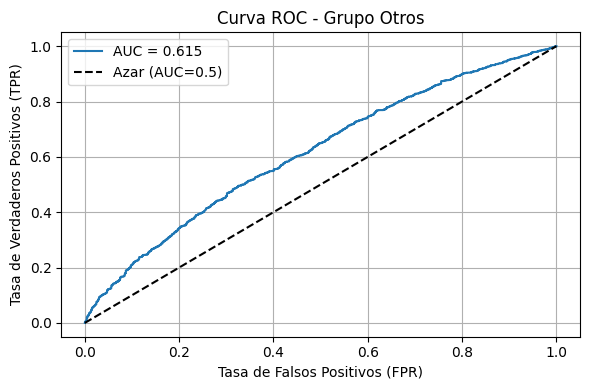

📊 Matriz de confusión:
 [[3605 2550]
 [2676 3493]]


In [30]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables del grupo "otros"
other_cols = [
    'no_speech_prob', 'entropy',
    'tense_past', 'tense_present', 'tense_future',
    'sentiment_polarity', 'sentiment_subjectivity'
]

# 2. Preparar X e y
X_other = df[other_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_other_scaled = scaler.fit_transform(X_other)

# 4. Crear DataFrame alineado con y
X_other_df = pd.DataFrame(X_other_scaled, columns=other_cols, index=y.index)
X_other_df = sm.add_constant(X_other_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_other_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_other_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Otros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))


📦 Análisis del grupo “Otros”
Este grupo incluye métricas de estilo lingüístico, uso del lenguaje y señales generales del contenido de voz.

📈 AUC = 0.615
Igual que el grupo de Voice Features (0.615).

Superior al azar (0.5), pero modesto por sí solo.

Esto indica que algunos patrones en el contenido y estructura del habla pueden tener relación con neurodivergencia, pero de forma débil si se toman aislados.

📋 Variables significativas:
| Variable         | Coef.  | Interpretación                                                                                  |
| ---------------- | ------ | ----------------------------------------------------------------------------------------------- |
| `no_speech_prob` | –0.194 | A mayor probabilidad de no haber habla en el audio, **menor** probabilidad de neurodivergencia. |
| `entropy`        | –0.251 | A menor entropía (más estructura en el discurso), **mayor** probabilidad de neurodivergencia.   |
| `tense_past`     | –0.290 | Uso del pasado reduce la probabilidad.                                                          |
| `tense_present`  | –0.176 | Uso del presente también la reduce.                                                             |
| `tense_future`   | –0.202 | Hablar del futuro también reduce probabilidad.                                                  |


____

## Comparativa de grupos: capacidad predictiva (Logit Models)

| Grupo                   | Nº Variables | AUC   | Variables Significativas (`p < 0.05`) | Observaciones clave                                                                                          |
| ----------------------- | ------------ | ----- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Facial**              | 7            | 0.568 | 6 de 7                                | Todas las emociones significativas (negativas), excepto sorpresa. Menor expresividad → más neurodivergencia. |
| **Personalidad**        | 12           | 0.663 | 7 de 12                               | `extraversion`, `conscientiousness`, y `openness` destacan. Grupo más predictivo.                            |
| **Estado emocional**    | 12           | 0.644 | 5 de 12                               | `stress_medium`, `self_efficacy_high`, `depression_medium`... varios patrones complejos.                     |
| **Voice Features**      | 12           | 0.615 | 7 de 12                               | `voice_median`, `IQR`, `Q25`, `Q75`... tono y modulación importantes.                                        |
| **Voice Emotions**      | 8            | 0.592 | 5 de 8                                | `sad_voice`, `neutral_voice`, `calm_voice`... emociones vocales útiles, pero débiles solas.                  |
| **Otros (lingüístico)** | 7            | 0.615 | 5 de 7                                | `entropy`, `tense_*`, `no_speech_prob` significativos. Refleja estructura narrativa.                         |

---

## Conclusiones generales

1. **Grupo más predictivo individualmente**: `🟢 Personalidad` (AUC = 0.663)
2. **Grupos complementarios útiles**: `Estado emocional`, `Voice Features`, y `Otros`
3. **Grupo menos informativo solo**: `Facial` (aunque con varias variables muy significativas)
4. **Muchas variables se solapan en lógica**: baja entropía, menor expresividad, mayor autocontrol...

---

## Que hacer
Odds Ratios?